In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

In [2]:
df = pd.read_csv('electricity/1.csv')

c:\users\dell\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#df.drop('Unnamed: 0',axis=1,inplace=True)
df

,timestamp,W,VAR,VA,f,VLN,PF,A
0,1369353600,0.0,0.0,0.0,49.997299,232.326004,0.0,0.0
1,1369353601,0.0,0.0,0.0,49.9949,232.326004,0.0,0.0
2,1369353602,0.0,0.0,0.0,49.9949,232.326004,0.0,0.0
3,1369353603,0.0,0.0,0.0,49.993099,232.311005,0.0,0.0
4,1369353604,0.0,0.0,0.0,49.991501,232.292999,0.0,0.0
...,...,...,...,...,...,...,...,...
4391054,1375716790,14.8999,0.0,26.733601,50.154499,241.912994,0.557348,0.110467
4391055,1375716791,14.8999,0.0,26.733601,50.154499,241.912994,0.557348,0.110467
4391056,1375716792,14.9037,0.0,26.712999,50.156399,241.932999,0.55792,0.110373
4391057,1375716795,14.9447,0.0,26.755301,50.159901,241.992004,0.558568,0.11052


In [12]:
df['TIMESTAMP']=pd.to_datetime(df['timestamp'], unit='s')
df['timestamp']=df['TIMESTAMP']
df.drop('TIMESTAMP',axis=1,inplace=True)

In [13]:
df.drop(['A','PF','f','VA','VAR','VLN'],axis=1,inplace=True)
#df.drop('VLN',axis=1,inplace=True)

In [14]:
df['Day']=pd.to_datetime(df['timestamp']).dt.dayofweek
df

,timestamp,W,Day
0,2013-05-24 00:00:00,0.0,4
1,2013-05-24 00:00:01,0.0,4
2,2013-05-24 00:00:02,0.0,4
3,2013-05-24 00:00:03,0.0,4
4,2013-05-24 00:00:04,0.0,4
...,...,...,...
4391054,2013-08-05 15:33:10,14.8999,0
4391055,2013-08-05 15:33:11,14.8999,0
4391056,2013-08-05 15:33:12,14.9037,0
4391057,2013-08-05 15:33:15,14.9447,0


In [15]:
df['Hour']=pd.to_datetime(df['timestamp']).dt.hour
df['Minute']=pd.to_datetime(df['timestamp']).dt.minute
df['Seconds']=pd.to_datetime(df['timestamp']).dt.second
df.drop('timestamp',axis=1,inplace=True)

In [16]:
df

,W,Day,Hour,Minute,Seconds
0,0.0,4,0,0,0
1,0.0,4,0,0,1
2,0.0,4,0,0,2
3,0.0,4,0,0,3
4,0.0,4,0,0,4
...,...,...,...,...,...
4391054,14.8999,0,15,33,10
4391055,14.8999,0,15,33,11
4391056,14.9037,0,15,33,12
4391057,14.9447,0,15,33,15


In [17]:
df['W']=pd.to_numeric(df['W'], errors='coerce')

In [18]:
df['W'].dtype

dtype('float64')

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
df_1=scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_1,columns=df.columns)
df_scaled

,W,Day,Hour,Minute,Seconds
0,0.000000,0.666667,0.000000,0.000000,0.000000
1,0.000000,0.666667,0.000000,0.000000,0.016949
2,0.000000,0.666667,0.000000,0.000000,0.033898
3,0.000000,0.666667,0.000000,0.000000,0.050847
4,0.000000,0.666667,0.000000,0.000000,0.067797
...,...,...,...,...,...
4391054,0.003520,0.000000,0.652174,0.559322,0.169492
4391055,0.003520,0.000000,0.652174,0.559322,0.186441
4391056,0.003521,0.000000,0.652174,0.559322,0.203390
4391057,0.003530,0.000000,0.652174,0.559322,0.254237


In [20]:
X=df_scaled.drop('W',axis=1)
y=df_scaled['W']

In [21]:
X = np.asarray(X).astype(np.float32)
y= np.asarray(y).astype(np.float32)

In [22]:
df_scaled.dropna(inplace=True)

In [23]:
df_scaled.isnull().sum()

W          0
Day        0
Hour       0
Minute     0
Seconds    0
dtype: int64

In [24]:
training_size=int(len(df)*0.80)
test_size=len(df)-training_size
X_train,y_train,X_test,y_test=df_scaled.iloc[0:training_size,1:5],df_scaled.iloc[0:training_size,0],df_scaled.iloc[training_size:len(df),1:5],df_scaled.iloc[training_size:len(df),0]
X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(3512847, 4) (3512847,) (878192, 4) (878192,)


In [25]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#y_train = y_train.reshape(-1, 1, 1)
#y_test = y_test.reshape(-1, 1, 1)

In [26]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,4)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             11000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,251
Trainable params: 31,251
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_history=model.fit(X_train, y_train, batch_size = 256,epochs = 20, validation_data=(X_test,y_test),verbose=1)

Epoch 1/20
13723/13723 [==============================] - 111s 7ms/step - loss: 0.0138 - val_loss: 0.0083
Epoch 2/20
13723/13723 [==============================] - 98s 7ms/step - loss: 0.0117 - val_loss: 0.0085
Epoch 3/20
13723/13723 [==============================] - 118s 9ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 4/20
13723/13723 [==============================] - 125s 9ms/step - loss: 0.0116 - val_loss: 0.0082
Epoch 5/20
13723/13723 [==============================] - 111s 8ms/step - loss: 0.0116 - val_loss: 0.0081
Epoch 6/20
13723/13723 [==============================] - 107s 8ms/step - loss: 0.0115 - val_loss: 0.0086
Epoch 7/20
13723/13723 [==============================] - 105s 8ms/step - loss: 0.0114 - val_loss: 0.0085
Epoch 8/20
13723/13723 [==============================] - 108s 8ms/step - loss: 0.0114 - val_loss: 0.0091
Epoch 9/20
13723/13723 [==============================] - 106s 8ms/step - loss: 0.0113 - val_loss: 0.0086
Epoch 10/20
13723/13723 [======================

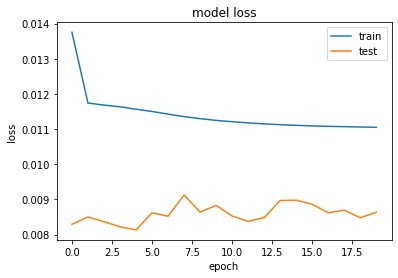

In [28]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [29]:
size = df.shape[1]

In [36]:
X_test.shape

(878192, 1, 4)

In [37]:
yhat = model.predict(X_test)

In [44]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [49]:
inv_yhat = np.concatenate((yhat, X_test[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

(878192,)

In [50]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(878192,)

In [51]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 393.288


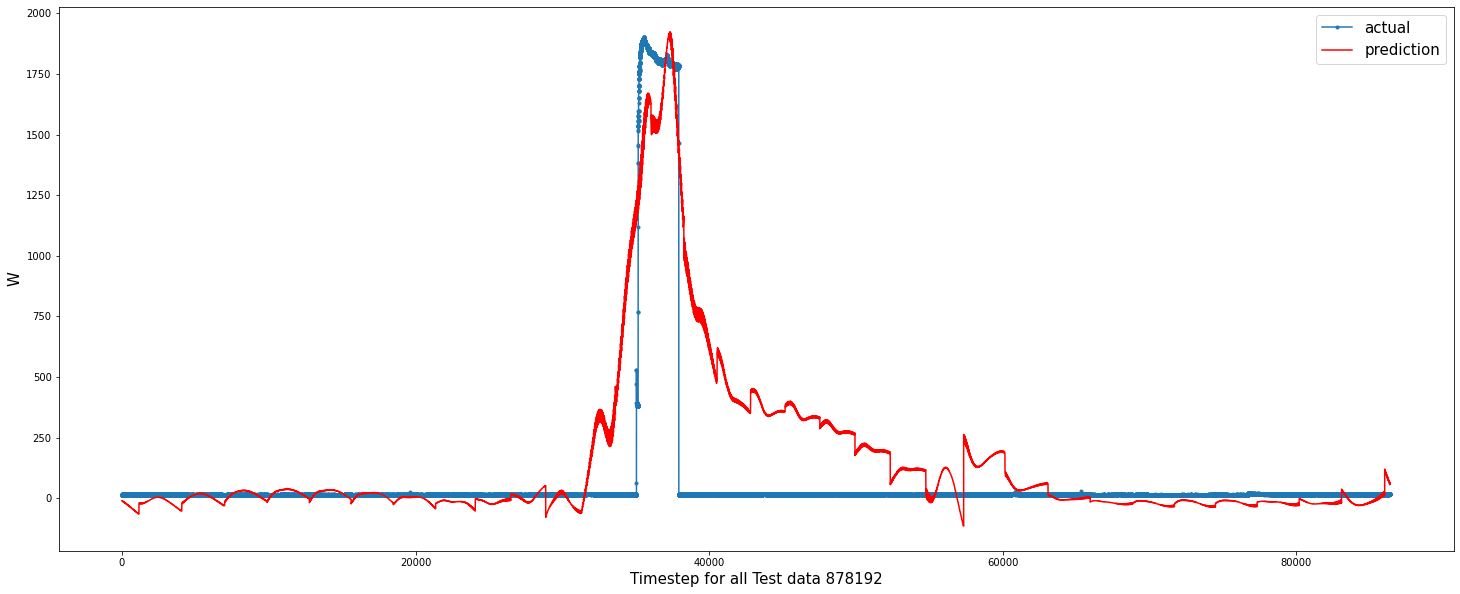

In [59]:
aa=[x for x in range(86400)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[86400:172800], marker='.', label="actual")
plt.plot(aa, inv_yhat[86400:172800], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Timestep for all Test data 878192', size=15)
plt.legend(fontsize=15)
plt.show()